# Training Machine Learning Models on Amazon SageMaker

## Setup

In [ ]:
# install tree command (helpful in printing folder structures)
!apt-get install tree

# setup AWS cli
!mkdir -p ~/.aws && cp /content/drive/MyDrive/AWS/d01_admin/* ~/.aws
!chmod 600 ~/.aws/credentials
!pip install awscli

# install boto3 and sagemaker
!pip install boto3
!pip install sagemaker

# install dependencies
!pip install pyathena
!pip install awswrangler
!pip install smclarify
!pip install sagemaker-experiments
!pip install sagemaker-tensorflow
!pip install smclarify
!pip install stepfunctions

# install nlp libs
!pip install transformers

In [84]:
# imports
import boto3
import sagemaker
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import io
import os
import sys
import time
import json
import csv
import sagemaker.amazon.common as smac
from sagemaker.image_uris import retrieve
from scipy.sparse import lil_matrix
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import JSONSerializer
from sagemaker.multidatamodel import MultiDataModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

In [58]:
# global variables
role = "sagemakerRole"
prefix = "sagemaker-exp11060346"
training_instance_type = "ml.m5.xlarge"

In [81]:
# setup sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role_arn = "arn:aws:iam::{}:role/{}".format(account_id, role)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)
runtime = boto3.Session().client(service_name='runtime.sagemaker')
runtime_sm_client = boto3.client('sagemaker-runtime')

## Factorization Machines on MovieLens

Download ml-100k dataset

In [59]:
!wget -q --show-progress http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip
%cd ml-100k
!shuf ua.base -o ua.base.shuffled
!head -5 ua.base.shuffled

ml-100k.zip         100%[===================>]   4.70M  5.70MB/s    in 0.8s    
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         
/c

Build training set and test set

In [61]:
num_users=943
num_movies=1682
num_features=num_users+num_movies

num_ratings_train=90570
num_ratings_test=9430

In [62]:
def loadDataset(filename, lines, columns):
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((lines, columns)).astype('float32')
    # Labels are stored in a vector
    Y = []
    line=0
    with open(filename,'r') as f:
        samples=csv.reader(f,delimiter='\t')
        for userId,movieId,rating,timestamp in samples:
            X[line,int(userId)-1] = 1
            X[line,int(num_users)+int(movieId)-1] = 1
            Y.append(int(rating))
            line=line+1       
    Y=np.array(Y).astype('float32')
    return X,Y

In [63]:
X_train, Y_train = loadDataset('ua.base.shuffled', num_ratings_train, num_features)
X_test, Y_test = loadDataset('ua.test', num_ratings_test, num_features)

In [64]:
print(X_train.shape)
print(Y_train.shape)
assert X_train.shape == (num_ratings_train, num_features)
assert Y_train.shape == (num_ratings_train, )

print(X_test.shape)
print(Y_test.shape)
assert X_test.shape  == (num_ratings_test, num_features)
assert Y_test.shape  == (num_ratings_test, )

(90570, 2625)
(90570,)
(9430, 2625)
(9430,)


Convert to protobuf and save to S3

In [67]:
train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train')

test_key       = 'test.protobuf'
test_prefix    = '{}/{}'.format(prefix, 'test')

output_prefix  = 's3://{}/{}/output'.format(bucket, prefix)

In [68]:
def writeDatasetToProtobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    # use smac.write_numpy_to_dense_tensor(buf, feature, label) for numpy arrays
    buf.seek(0)
    print(buf)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
train_data = writeDatasetToProtobuf(X_train, Y_train, bucket, train_prefix, train_key)    
test_data  = writeDatasetToProtobuf(X_test, Y_test, bucket, test_prefix, test_key)    
  
print(train_data)
print(test_data)
print('Output: {}'.format(output_prefix))

s3://sagemaker-us-east-1-390354360073/sagemaker-exp11060346/train/train.protobuf
s3://sagemaker-us-east-1-390354360073/sagemaker-exp11060346/test/test.protobuf
Output: s3://sagemaker-us-east-1-390354360073/sagemaker-exp11060346/output


Run training job

In [70]:
container = retrieve('factorization-machines', region)

fm = Estimator(
    container,
    role=role,
    instance_count=1,
    instance_type='ml.c5.xlarge',
    output_path=output_prefix)

fm.set_hyperparameters(
    feature_dim=num_features,
    predictor_type='regressor',
    num_factors=64,
    epochs=10)

fm.fit({'train': train_data, 'test': test_data})

2022-06-11 06:55:33 Starting - Starting the training job...
2022-06-11 06:55:55 Starting - Preparing the instances for trainingProfilerReport-1654930532: InProgress
......
2022-06-11 06:56:58 Downloading - Downloading input data...
2022-06-11 06:57:31 Training - Downloading the training image...
2022-06-11 06:58:09 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:87: DeprecationWarning: invalid escape sequence \s
  """
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:120: DeprecationWarning: invalid escape sequ

Deploy model

In [71]:
fm_predictor = fm.deploy(
    endpoint_name='fm-movielens-100k',
    instance_type='ml.t2.medium',
    initial_instance_count=1)

----------!

![](https://drive.google.com/uc?id=1enWKwI26kefSCsNkVAlBm2rcOu9s0CaS&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

In [72]:
class FMSerializer(JSONSerializer):
    def serialize(self, data):
       js = {'instances': []}
       for row in data:
              js['instances'].append({'features': row.tolist()})
       return json.dumps(js)

fm_predictor.serializer = FMSerializer()
fm_predictor.deserializer = JSONDeserializer()

Run predictions

In [74]:
result = fm_predictor.predict(X_test[:3].toarray())
print(result)

{'predictions': [{'score': 3.40897274017334}, {'score': 3.4403507709503174}, {'score': 3.656045913696289}]}


## Linear Learner on Boston Housing Dataset

In [73]:
dataset = pd.read_csv('https://github.com/RecoHut-Datasets/synthetic_text/raw/main/housing.csv')
dataset

,crim,zn,indus,chas,nox,age,rm,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,6.48,22.0


In [75]:
# Move 'medv' column to front
dataset = pd.concat([dataset['medv'], dataset.drop(['medv'], axis=1)], axis=1)

from sklearn.model_selection import train_test_split
training_dataset, validation_dataset = train_test_split(dataset, test_size=0.1)

print(training_dataset.shape)
print(validation_dataset.shape)

training_dataset.to_csv('training_dataset.csv', index=False, header=False)
validation_dataset.to_csv('validation_dataset.csv', index=False, header=False)

training_data_path = sess.upload_data(path='training_dataset.csv', key_prefix=prefix + '/input/training')
validation_data_path = sess.upload_data(path='validation_dataset.csv', key_prefix=prefix + '/input/validation')

print(training_data_path)
print(validation_data_path)

(455, 13)
(51, 13)
s3://sagemaker-us-east-1-390354360073/sagemaker-exp11060346/input/training/training_dataset.csv
s3://sagemaker-us-east-1-390354360073/sagemaker-exp11060346/input/validation/validation_dataset.csv


In [76]:
container = retrieve('linear-learner', region)
print(container)

ll_estimator = Estimator(container,
    role=role, 
    instance_count=1,
    instance_type='ml.m5.large',
    output_path='s3://{}/{}/output'.format(bucket, prefix)
)

ll_estimator.set_hyperparameters(
    predictor_type='regressor', 
    mini_batch_size=32)

382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


In [77]:
training_data_channel   = TrainingInput(s3_data=training_data_path, content_type='text/csv')
validation_data_channel = TrainingInput(s3_data=validation_data_path, content_type='text/csv')

ll_data = {'train': training_data_channel, 'validation': validation_data_channel}
ll_estimator.fit(ll_data)

2022-06-11 07:04:51 Starting - Starting the training job...
2022-06-11 07:05:10 Starting - Preparing the instances for trainingProfilerReport-1654931090: InProgress
......
2022-06-11 07:06:26 Downloading - Downloading input data......
2022-06-11 07:07:26 Training - Downloading the training image...
2022-06-11 07:07:57 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/11/2022 07:08:06 INFO 139779129902912] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias':

In [78]:
timestamp = time.strftime('%d-%H-%M-%S', time.gmtime())

endpoint_name = 'linear-learner-demo-'+timestamp
print(endpoint_name)

linear-learner-demo-11-07-08-47


In [79]:
ll_predictor = ll_estimator.deploy(endpoint_name=endpoint_name, 
                        initial_instance_count=1, 
                        instance_type='ml.t2.medium')

test_sample = '0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,4.98'
ll_predictor.serializer = sagemaker.serializers.CSVSerializer()
ll_predictor.deserializer = sagemaker.deserializers.CSVDeserializer()

response = ll_predictor.predict(test_sample)
print(response)

-----------![['30.464845657348633']]


![](https://drive.google.com/uc?id=1eo5J8WeN_rYRIuFM6LoTrb3AUvEjiYxH&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

In [80]:
test_samples = ['0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,4.98',
                '0.02731,0.00,7.070,0,0.4690,6.4210,78.90,4.9671,2,242.0,17.80,9.14']

response = ll_predictor.predict(test_samples)
print(response)

[['30.464845657348633'], ['24.862537384033203']]


In [82]:
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                  ContentType='text/csv',
                                  Body=test_sample)

print(json.loads(response['Body'].read()))

{'predictions': [{'score': 30.464845657348633}]}


## Random Cut Forest on Electric Power Consumption Dataset

In [90]:
df = pd.read_csv('https://github.com/RecoHut-Datasets/synthetic_text/raw/main/item-demand-time.csv',
                 dtype = object, names=['timestamp','value','item'])
df.head(3)

,timestamp,value,item
0,2014-01-01 01:00:00,38.34991708126038,client_12
1,2014-01-01 02:00:00,33.5820895522388,client_12
2,2014-01-01 03:00:00,34.41127694859037,client_12


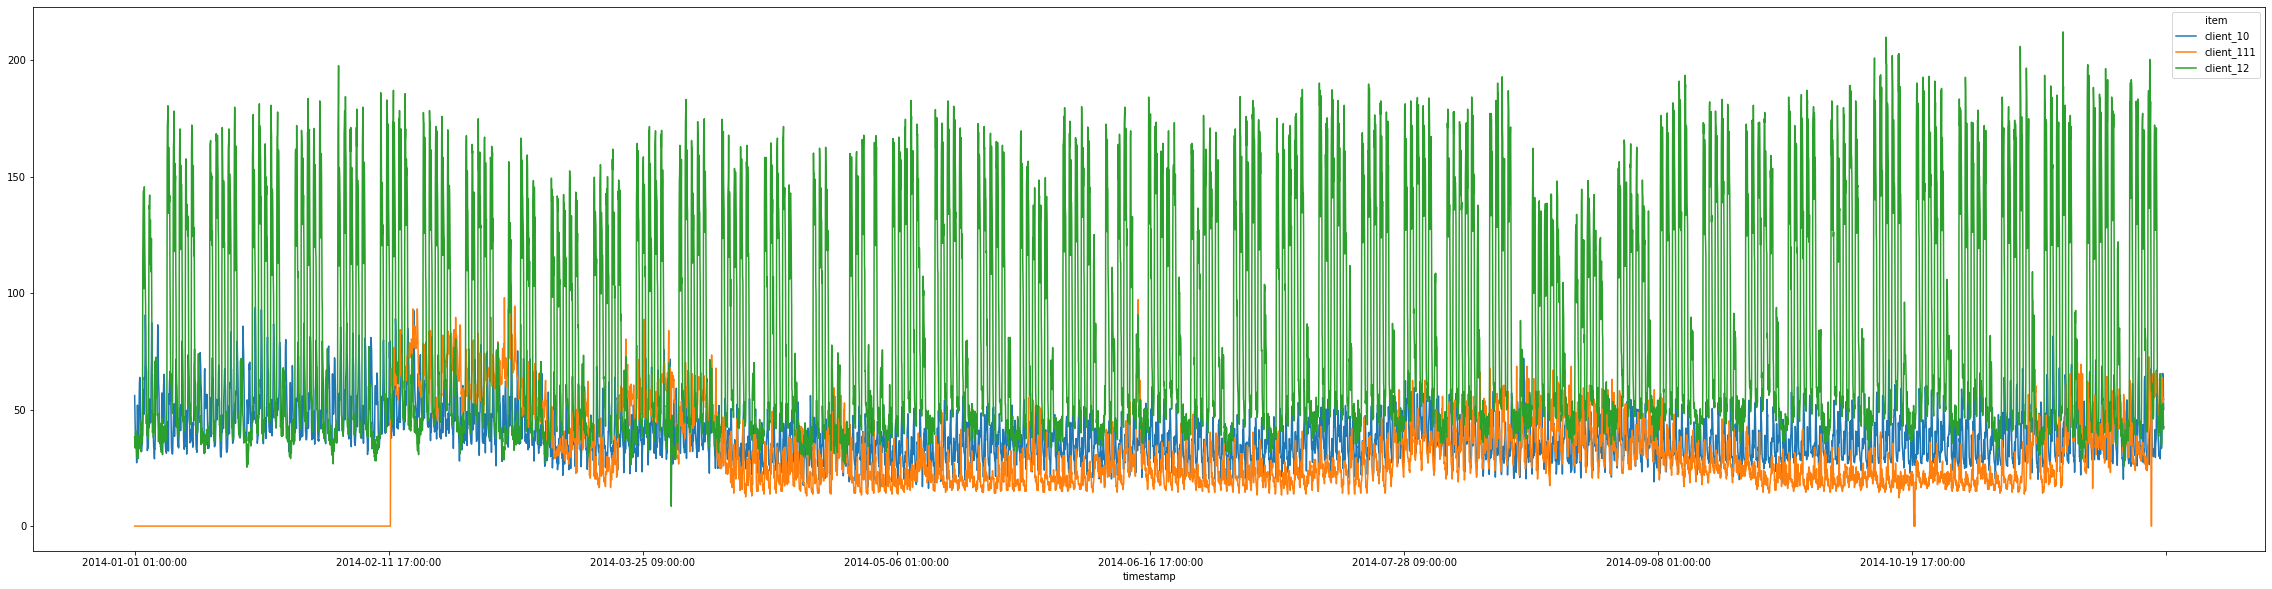

In [91]:
df.value=pd.to_numeric(df.value)
df_plot = df.pivot(index='timestamp', columns='item', values='value')
df_plot.plot(figsize=(40,10))
df = df[df['item']=='client_12']
df = df.drop(['item', 'timestamp'], axis=1)
df.value = df.value.astype('float32')
df.value*=100
df.value = df.value.astype('int32')
df.head(3)
plt.show()

In [92]:
df.to_csv('electricity.csv', index=False, header=False)

In [93]:
training_data_path = sess.upload_data(path='electricity.csv', key_prefix=prefix + '/input/training')

training_data_channel = sagemaker.TrainingInput(s3_data=training_data_path, 
                                           content_type='text/csv;label_size=0',
                                           distribution='ShardedByS3Key')

rcf_data = {'train': training_data_channel}
print(training_data_path)

s3://sagemaker-us-east-1-390354360073/sagemaker-exp11060346/input/training/electricity.csv


In [94]:
container = retrieve('randomcutforest', region)

rcf_estimator = Estimator(
    container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path='s3://{}/{}/output'.format(bucket, prefix))

rcf_estimator.set_hyperparameters(feature_dim=1)

rcf_estimator.fit(rcf_data)

2022-06-11 07:15:57 Starting - Starting the training job...
2022-06-11 07:16:22 Starting - Preparing the instances for trainingProfilerReport-1654931756: InProgress
.........
2022-06-11 07:18:02 Downloading - Downloading input data
2022-06-11 07:18:02 Training - Downloading the training image.........
2022-06-11 07:19:36 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/11/2022 07:19:45 INFO 139997972080448] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[06/11/2022 07:19:45 INFO 139997972080448

In [95]:
timestamp = time.strftime('%d-%H-%M-%S', time.gmtime())

endpoint_name = 'rcf-demo'+'-'+timestamp

rcf_predictor = rcf_estimator.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type='ml.t2.medium')

rcf_predictor.serializer = sagemaker.serializers.CSVSerializer()
rcf_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

values = df['value'].astype('str').tolist()
response = rcf_predictor.predict(values)

------------!

![](https://drive.google.com/uc?id=1epbdhTUFyEBuq8ixlP1pmi34MMfEtuh6&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

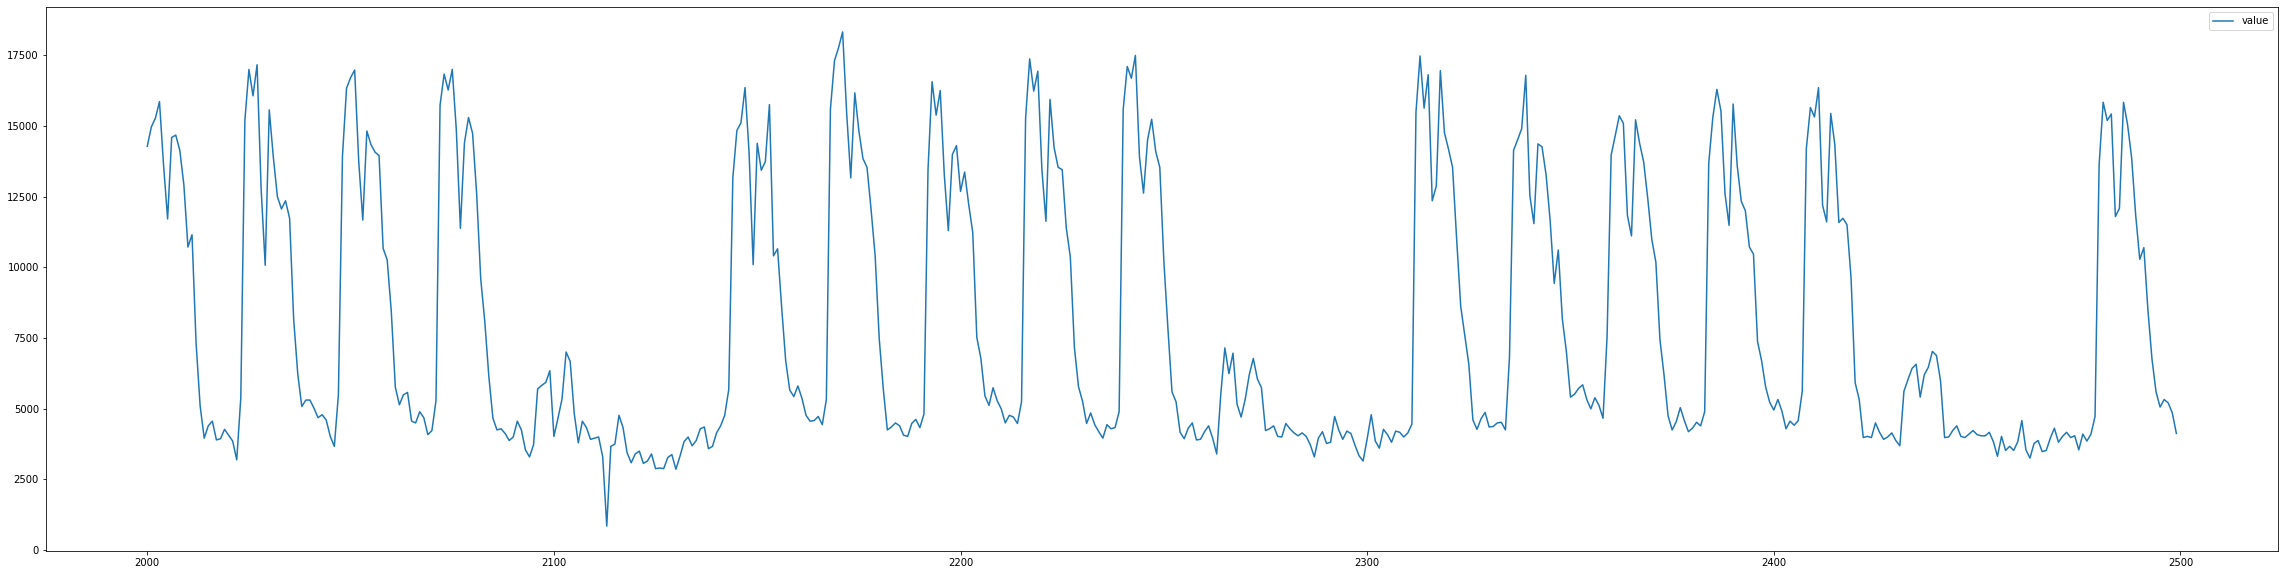

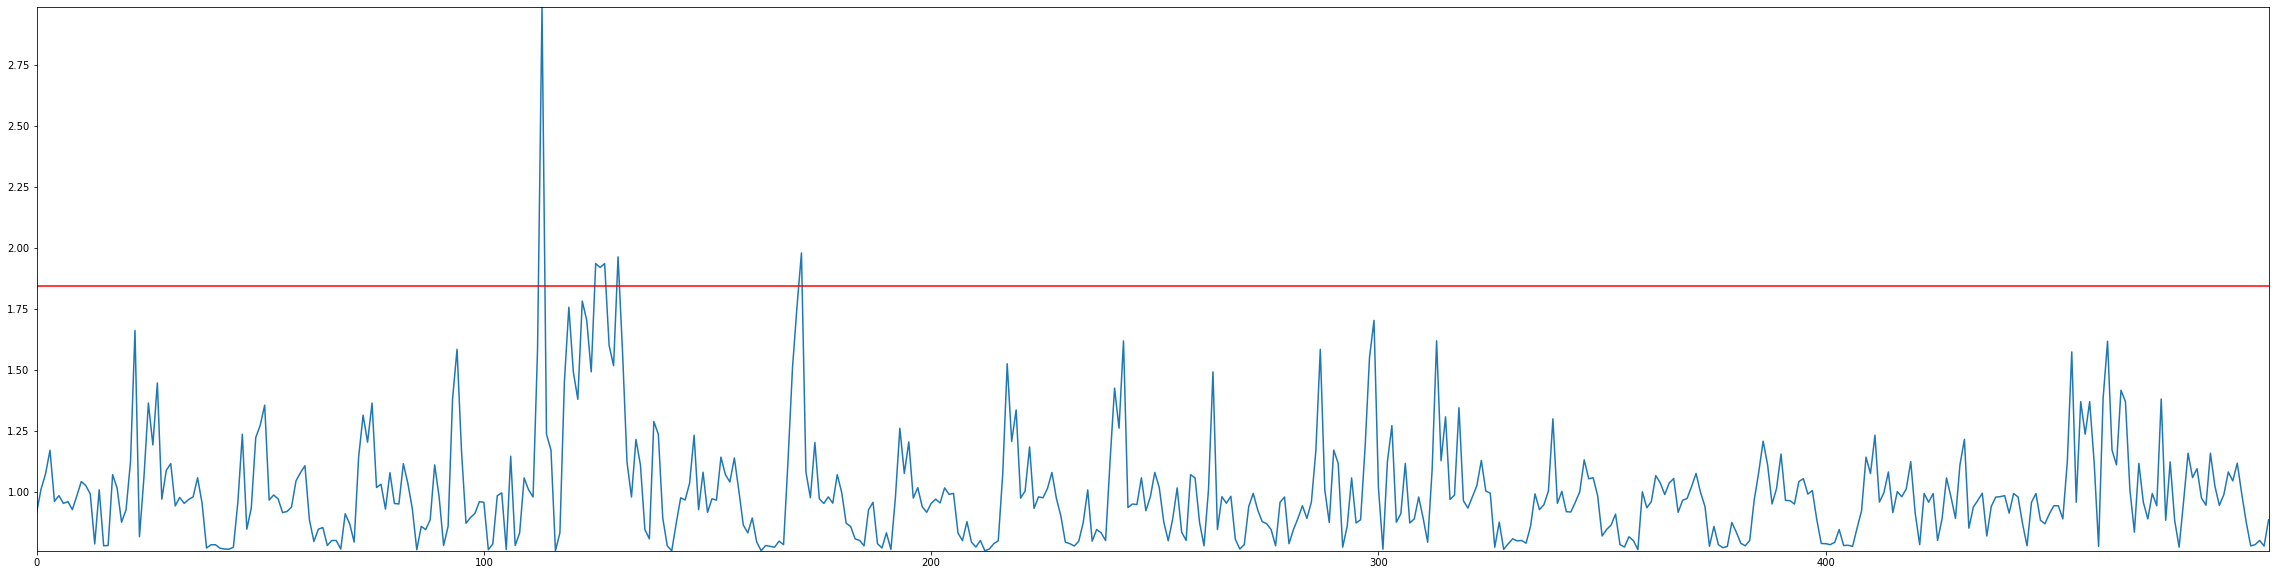

In [96]:
from statistics import mean, stdev

scores = []
for s in response['scores']:
    scores.append(s['score'])
    
score_mean = mean(scores)
score_std = stdev(scores)

df[2000:2500].plot(figsize=(40,10))
plt.figure(figsize=(40,10))
plt.plot(scores[2000:2500])
plt.autoscale(tight=True)
plt.axhline(y=score_mean+3*score_std, color='red')
plt.show()

That's all.

Thanks for your attention.